In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [3]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes        165           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        298           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        899           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       5550           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      44469           False  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge      11555           False  
connectx

In [4]:
!kaggle competitions download -c tabular-playground-series-jun-2021

  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 38.9MB/s]
  0% 0.00/6.49M [00:00<?, ?B/s]
100% 6.49M/6.49M [00:00<00:00, 59.7MB/s]
  0% 0.00/3.14M [00:00<?, ?B/s]
100% 3.14M/3.14M [00:00<00:00, 104MB/s]


In [5]:
!unzip train.csv

Archive:  train.csv.zip
  inflating: train.csv               


In [6]:
!unzip test.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                


In [7]:
!unzip sample_submission.csv.zip

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [9]:
df = pd.read_csv("train.csv")
df.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,target
0,0,0,0,6,1,0,0,0,0,7,0,0,0,3,0,1,0,0,3,3,1,0,2,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,11,0,0,0,0,0,9,0,0,0,0,0,0,3,0,1,3,0,0,0,0,0,0,0,1,1,0,0,3,0,0,0,0,0,0,2,0,0,Class_6
1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,Class_6
2,2,0,0,0,0,0,1,0,3,0,0,1,0,0,0,0,0,0,0,0,5,4,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,5,0,5,0,1,0,0,0,1,0,0,1,0,7,0,1,1,0,3,4,0,0,1,3,0,2,0,0,8,0,0,0,0,1,0,0,0,0,Class_2
3,3,0,0,7,0,1,5,2,2,0,1,2,0,5,0,0,4,0,0,22,2,1,0,0,0,0,3,0,37,0,1,3,13,0,10,0,3,1,1,0,7,0,0,2,0,1,0,0,0,0,0,0,10,0,0,25,1,0,1,2,0,2,0,7,0,0,0,0,4,0,2,2,0,4,3,0,Class_8
4,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Class_2


In [10]:
df1 = pd.read_csv("test.csv")

Looking at the distribution of 'target variable'

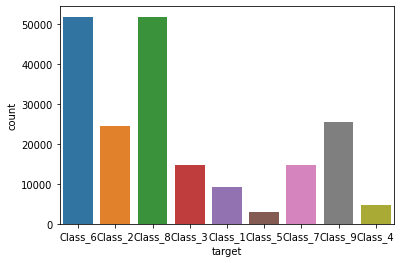

In [12]:
sns.countplot(x = 'target', data=df)


Encoding output class

In [13]:
class2idx = {
    "Class_1":0,
    "Class_2":1,
    "Class_3":2,
    "Class_4":3,
    "Class_5":4,
    "Class_6":5,
    "Class_7":6,
    "Class_8":7,
    "Class_9":8
}

idx2class = {v: k for k, v in class2idx.items()}

df['target'].replace(class2idx, inplace=True)

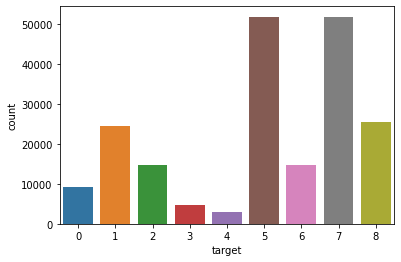

In [14]:
sns.countplot(x = 'target', data=df)


Creating Input and Output data


In [15]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [16]:
X_test = df1.iloc[:,:]

First we’ll split our data into train and val sets. 

Because there’s a class imbalance, we want to have equal distribution of all output classes in our train and  validation sets. To do that, we use the stratify option in function train_test_split().

In [17]:
# Split into train+val and test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

In [18]:
X_train.shape

(160000, 76)

In [19]:
X_test.shape

(100000, 76)

Neural networks need data that lies between the range of (0,1). There’s a ton of material available online on why we need to do it.
To scale our values, we’ll use the MinMaxScaler() from Sklearn. The MinMaxScaler transforms features by scaling each feature to a given range which is (0,1) in our case.


In [20]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test = np.array(X_test)

Visualize Class Distribution in Train and Val sets


In [21]:
def get_class_distribution(obj):
    count_dict = {
      "Class_1":0,
      "Class_2":1,
      "Class_3":2,
      "Class_4":3,
      "Class_5":4,
      "Class_6":5,
      "Class_7":6,
      "Class_8":7,
      "Class_9":8
    }
    
    for i in obj:
        if i == 0: 
            count_dict['Class_1'] += 1
        elif i == 1: 
            count_dict['Class_2'] += 1
        elif i == 2: 
            count_dict['Class_3'] += 1
        elif i == 3: 
            count_dict['Class_4'] += 1
        elif i == 4: 
            count_dict['Class_5'] += 1  
        elif i == 5: 
            count_dict['Class_6'] += 1
        elif i == 6: 
            count_dict['Class_7'] += 1
        elif i == 7: 
            count_dict['Class_8'] += 1
        elif i == 8: 
            count_dict['Class_9'] += 1
                      
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Val Set')

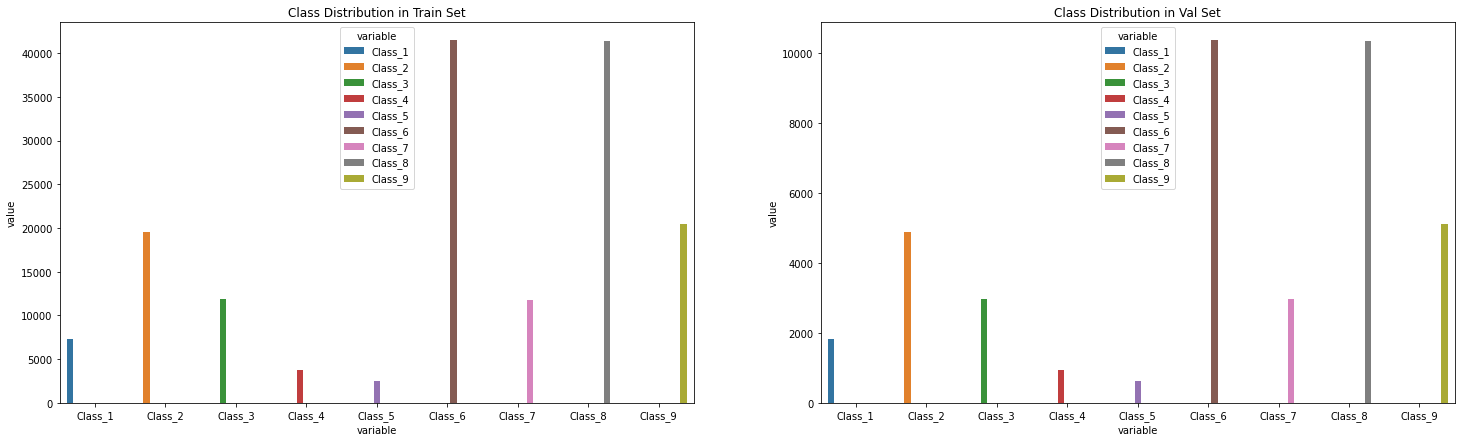

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')


Custom Dataset
First up, let’s define a custom dataset. This dataset will be used by the dataloader to pass our data into our model.
We initialize our dataset by passing X and y as inputs. Make sure X is a float while y is long.

In [23]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)



train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())


Weighted Sampling

Because there’s a class imbalance, we use stratified split to create our train and  validation sets.
While it helps, it still does not ensure that each mini-batch of our model see’s all our classes. We need to over-sample the classes with less number of values. To do that, we use the WeightedRandomSampler.
First, we obtain a list called target_list which contains all our outputs. This list is then converted to a tensor and shuffled.

In [24]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [ ]:
# count = 0
# for _, t in train_dataset:
#     print(t,' ')
#     count += 1
#     if count == 10 :
#         break

Then, we obtain the count of all classes in our training set. We use the reciprocal of each count to obtain it’s weight.

In [25]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 

print(class_weights)

tensor([1.3710e-04, 5.1161e-05, 8.4459e-05, 2.6553e-04, 4.0733e-04, 2.4123e-05,
        8.4595e-05, 2.4144e-05, 4.8919e-05])


WeightedRandomSampler expects a weight for each sample. We do that using as follows.

In [26]:
class_weights_all = class_weights[target_list]

In [27]:
class_weights_all.size()

torch.Size([160000])

Finally, let’s initialize our WeightedRandomSampler. We’ll call this in our dataloader below.


In [28]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

Before we proceed any further, let’s define a few parameters that we’ll use down the line.


In [31]:
EPOCHS = 25
BATCH_SIZE = 20
LEARNING_RATE = 0.007
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 9

For train_dataloader we’ll use batch_size = 64 and pass our sampler to it. Note that we’re not using shuffle=True in our train_dataloader because we’re already using a sampler. These two are mutually exclusive.

In [33]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)


Define Neural Net Architecture

In [34]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 256)
        self.layer_2 = nn.Linear(256, 128)
        self.layer_3 = nn.Linear(128, 64)
        
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(256)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [36]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=76, out_features=256, bias=True)
  (layer_2): Linear(in_features=256, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=9, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


Before we start our training, let’s define a function to calculate accuracy per epoch.
This function takes y_pred and y_test as input arguments. We then apply log_softmax to y_pred and extract the class which has a higher probability.
After that, we compare the the predicted classes and the actual classes to calculate the accuracy

In [37]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

We’ll also define 2 dictionaries which will store the accuracy/epoch and loss/epoch for both train and validation sets.


In [38]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [ ]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


Epoch 001: | Train Loss: 2.13480 | Val Loss: 2.12227 | Train Acc: 27.331| Val Acc: 27.418
Epoch 002: | Train Loss: 2.11821 | Val Loss: 2.11607 | Train Acc: 28.905| Val Acc: 28.023
Epoch 003: | Train Loss: 2.11004 | Val Loss: 2.11518 | Train Acc: 27.677| Val Acc: 30.595
Epoch 004: | Train Loss: 2.10383 | Val Loss: 2.12082 | Train Acc: 28.149| Val Acc: 29.720


In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving model_weights.pth to model_weights.pth


In [ ]:
model =  MulticlassClassification(NUM_FEATURES,NUM_CLASSES)
model.load_state_dict(torch.load('model_weights.pth'))

<All keys matched successfully>

In [ ]:
X_test

array([[1.000005  , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.00001   , 0.01639344, 0.03921569, ..., 0.04918033, 0.        ,
        0.        ],
       [1.000015  , 0.        , 0.01960784, ..., 0.03278689, 0.        ,
        0.        ],
       ...,
       [1.4999925 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.03846154],
       [1.4999975 , 0.        , 0.        , ..., 0.01639344, 0.        ,
        0.        ],
       [1.5000025 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
Xt = torch.from_numpy(X_test).float()
#X_test = Xt.to(device)
y_predtest = model(Xt)

In [ ]:
m = nn.Softmax(dim=1)
y = m(y_predtest)

In [ ]:
y_p = y.cpu().detach().numpy()

In [ ]:
y[680]

tensor([0.1017, 0.1122, 0.1205, 0.0878, 0.0597, 0.1142, 0.1221, 0.1444, 0.1375],
       grad_fn=<SelectBackward>)

In [ ]:
y_p

array([[0.1174432 , 0.30804765, 0.19676457, ..., 0.02209041, 0.02239625,
        0.09520973],
       [0.11206818, 0.09179471, 0.1018776 , ..., 0.13402636, 0.15701358,
        0.13779572],
       [0.1117758 , 0.12579255, 0.12277985, ..., 0.08920217, 0.10631042,
        0.12402745],
       ...,
       [0.11429511, 0.226479  , 0.18503967, ..., 0.04920413, 0.05209852,
        0.12233023],
       [0.0951243 , 0.10423514, 0.12767775, ..., 0.08158863, 0.10255768,
        0.10439003],
       [0.10925166, 0.08643463, 0.10080685, ..., 0.12551956, 0.15217128,
        0.12863955]], dtype=float32)

In [ ]:
y_p.shape

(100000, 9)

In [ ]:
y_p

array([[0.1174432 , 0.30804765, 0.19676457, ..., 0.02209041, 0.02239625,
        0.09520973],
       [0.11206818, 0.09179471, 0.1018776 , ..., 0.13402636, 0.15701358,
        0.13779572],
       [0.1117758 , 0.12579255, 0.12277985, ..., 0.08920217, 0.10631042,
        0.12402745],
       ...,
       [0.11429511, 0.226479  , 0.18503967, ..., 0.04920413, 0.05209852,
        0.12233023],
       [0.0951243 , 0.10423514, 0.12767775, ..., 0.08158863, 0.10255768,
        0.10439003],
       [0.10925166, 0.08643463, 0.10080685, ..., 0.12551956, 0.15217128,
        0.12863955]], dtype=float32)

In [ ]:
ss = pd.read_csv("sample_submission.csv")

In [ ]:
ss.tail()

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
99995,299995,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111
99996,299996,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111
99997,299997,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111
99998,299998,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111
99999,299999,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111


In [ ]:
l = [i for i in range(100000)]

In [ ]:
l[-1]

99999

In [ ]:
str(1)

'1'

In [ ]:
for i in range(100000):
  for j in range(9):
    ss.loc[i, "Class_" + str(j+1)] = y_p[i][j]


In [ ]:
#ss.loc[0, "Class_" + str(0+1)] = 0

In [43]:
ss.tail()

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
99995,299995,0.113991,0.239088,0.191817,0.101616,0.067073,0.057407,0.049005,0.050305,0.129699
99996,299996,0.115635,0.200762,0.174112,0.099417,0.063604,0.085210,0.062454,0.066853,0.131953
99997,299997,0.114295,0.226479,0.185040,0.099615,0.062045,0.088893,0.049204,0.052099,0.122330
99998,299998,0.095124,0.104235,0.127678,0.088006,0.046462,0.249959,0.081589,0.102558,0.104390
99999,299999,0.109252,0.086435,0.100807,0.088522,0.055848,0.152807,0.125520,0.152171,0.128640


In [44]:
ss.reset_index(inplace=True)
ss.drop('index', axis=1, inplace=True)


In [45]:
ss.to_csv("submission.csv")

In [ ]:
s2 = pd.read_csv("submission.csv")

In [ ]:
s2.head()

,Unnamed: 0,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,0,200000,0.025055,0.076429,0.145411,0.032765,0.582515,0.085108,0.009507,0.017830,0.025379
1,1,200001,0.021187,0.152956,0.122381,0.053627,0.415584,0.107362,0.031640,0.032657,0.062605
2,2,200002,0.073335,0.312314,0.200403,0.034172,0.084821,0.066079,0.052044,0.051368,0.125465
3,3,200003,0.087889,0.243612,0.237738,0.043734,0.066282,0.069102,0.055396,0.047413,0.148833
4,4,200004,0.091281,0.003922,0.000705,0.000003,0.816956,0.024114,0.011249,0.046269,0.005500


In [ ]:
s2.columns

Index(['Unnamed: 0', 'id', 'Class_1', 'Class_2', 'Class_3', 'Class_4',
       'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9'],
      dtype='object')

In [ ]:
s2.drop